In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import numpy as np

TODO (things wei ann the guinea pig did not understand)
- Explain shape of data, dataframes are not a common concept for non-python users
- Explain transfer learning
- Explain the keras functional API (less important)
- Explanations on validation/training data set and dangers of overfitting
- Explain results of walkthrough (pre-challenge) so that participants have a clear goal of what a "better" result looks like (validation loss/training loss)

## Get Dataset

Dataset citation: 3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
       
Currently some hacky code to switch to a vehicle-type task. 
TODO: Move out of notebook, ideally shrink size of dataset so we can download it as part of the docker image.

In [2]:
(train_dataset, validation_dataset, test_dataset), dataset_info = tfds.load(
    "cars196",
    # Reserve 10% for validation and also get the test set
    split=["train[:80%]", "train[80%:90%]", "test[:100%]"],
    as_supervised=True,  # Include labels
    with_info=True # Load dataset info as well
)

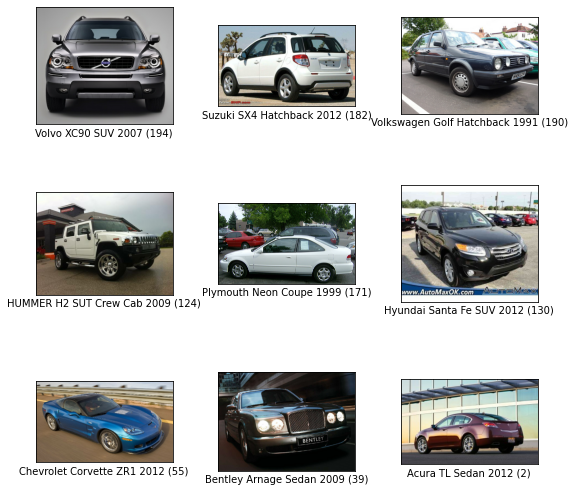

In [3]:
# Have a look at the images in the dataset
fig = tfds.show_examples(train_dataset, dataset_info)

In [4]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset))

Number of training samples: 6515
Number of validation samples: 815
Number of test samples: 8041


In [5]:
IMG_SIZE = (160, 160)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [6]:
# Map class labels to vehicle type
original_class_names = dataset_info.features['label'].names
mapping = pd.read_csv('vehicle_class_names.csv').set_index('mmy')
mapping['vehicle_type_int'] = mapping['vehicle_type'].map({'Convertible': 0, 
                                        'Coupe': 0, 
                                        'Hatchback': 0,
                                        'Minivan': 0, 
                                        'SUV': 1, 
                                        'Sedan': 0,
                                        'Truck': 2, 
                                        'Van': 3,
                                        'Wagon': 0
                                        })
mapping = mapping.to_dict(orient='index')

def map_class_label(label_value):
    mmy = original_class_names[int(label_value)]
    new_label = mapping[mmy]['vehicle_type_int']
    return new_label

In [7]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.py_function(func=map_class_label,
                    inp=[y], Tout=tf.int64)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.py_function(func=map_class_label,
                        inp=[y], Tout=tf.int64)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.py_function(func=map_class_label,
                        inp=[y], Tout=tf.int64)))

In [8]:
def set_shapes(label):
    label.set_shape([])
    return label

train_dataset = train_dataset.map(lambda img, label: (img, set_shapes(label)))
validation_dataset = validation_dataset.map(lambda img, label: (img, set_shapes(label)))
test_dataset = test_dataset.map(lambda img, label: (img, set_shapes(label)))

In [9]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Build a data pipeline

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

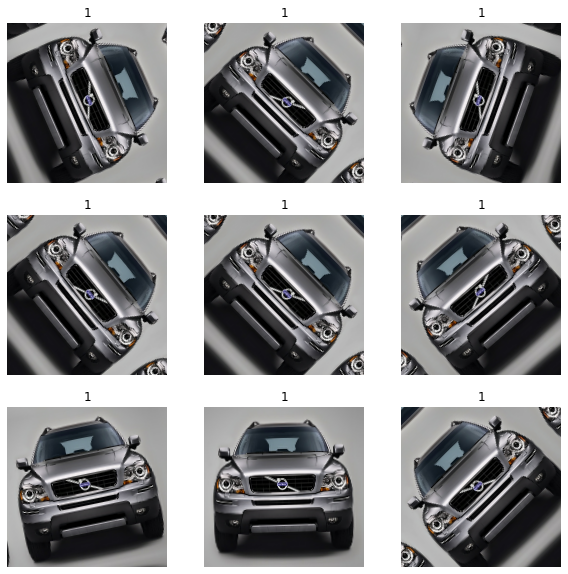

In [11]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Rescale pixel values
We are going to download tf.keras.applications.MobileNetV2 as base mode which expects pixel values in [-1,1]. Current pixel images are [0-255], needs rescaling via pre-processing

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Create base model from pre-trained covnets

Create base model from MobileNet V2 model developed at Google, which is pre-trained on ImageNet dataset with a wide variety of categories.
This base knowledge will help us classify cats and dogs

As with most machine learning models, MobileNet V2 comes in "layers". The last classification layer (the top of the model) is not very useful. Instead, it is common practice to use on the very last layer before the flatten operation. This layer is called the "bottleneck layer" which retain more generality.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

TODO: Add summary of mobilenet v2. Diagram. Example of how it performs alone.

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature extraction

Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [15]:
base_model.trainable = False

Important note about BatchNormalization layers
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

TODO: Relate base model back to mobilenets diagram

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.




In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 4)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [20]:
len(model.trainable_variables)

2

Actually train the model!!

In [21]:
initial_epochs = 10
# With no training
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 279ms/step - loss: 1.4742 - accuracy: 0.2972


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.50
initial accuracy: 0.27


In [23]:
# Now is a very good time to talk about what's happening + how weights
# are updated.
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
204/204 [==============================] - 83s 398ms/step - loss: 1.0280 - accuracy: 0.6216 - val_loss: 0.7693 - val_accuracy: 0.6785
Epoch 2/10
204/204 [==============================] - 73s 360ms/step - loss: 0.8219 - accuracy: 0.6890 - val_loss: 0.6335 - val_accuracy: 0.7227
Epoch 3/10
204/204 [==============================] - 73s 360ms/step - loss: 0.7425 - accuracy: 0.7151 - val_loss: 0.5595 - val_accuracy: 0.7681
Epoch 4/10
204/204 [==============================] - 74s 362ms/step - loss: 0.6872 - accuracy: 0.7306 - val_loss: 0.5169 - val_accuracy: 0.7926
Epoch 5/10
204/204 [==============================] - 73s 360ms/step - loss: 0.6632 - accuracy: 0.7452 - val_loss: 0.4851 - val_accuracy: 0.8025
Epoch 6/10
204/204 [==============================] - 72s 355ms/step - loss: 0.6342 - accuracy: 0.7503 - val_loss: 0.4669 - val_accuracy: 0.8135
Epoch 7/10
204/204 [==============================] - 73s 356ms/step - loss: 0.6170 - accuracy: 0.7555 - val_loss: 0.4489 - val_ac

Expectation: after training for 10 epochs, see 94% data accuracy

Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

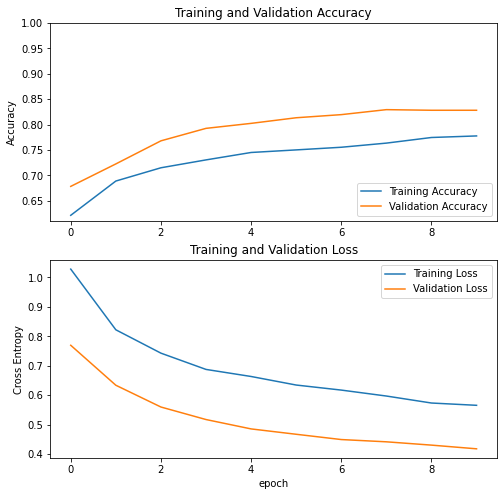

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tuning! This is where the challenge can start

From tutorial: 
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.
Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


Compile the model

In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

56

Continue training the model - if trained to convergence earlier this will improve your model

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
204/204 [==============================] - 112s 534ms/step - loss: 0.5531 - accuracy: 0.7789 - val_loss: 0.3746 - val_accuracy: 0.8331
Epoch 11/20
204/204 [==============================] - 109s 532ms/step - loss: 0.4799 - accuracy: 0.8114 - val_loss: 0.3475 - val_accuracy: 0.8712
Epoch 12/20
204/204 [==============================] - 108s 528ms/step - loss: 0.4541 - accuracy: 0.8234 - val_loss: 0.3613 - val_accuracy: 0.8626
Epoch 13/20
204/204 [==============================] - 109s 533ms/step - loss: 0.4246 - accuracy: 0.8328 - val_loss: 0.3128 - val_accuracy: 0.8736
Epoch 14/20
204/204 [==============================] - 108s 531ms/step - loss: 0.3989 - accuracy: 0.8410 - val_loss: 0.2993 - val_accuracy: 0.8896
Epoch 15/20
204/204 [==============================] - 110s 538ms/step - loss: 0.3875 - accuracy: 0.8485 - val_loss: 0.2860 - val_accuracy: 0.8945
Epoch 16/20
204/204 [==============================] - 109s 534ms/step - loss: 0.3571 - accuracy: 0.8541 - val_loss: 0

Results of fine tuning: 98% accuracy

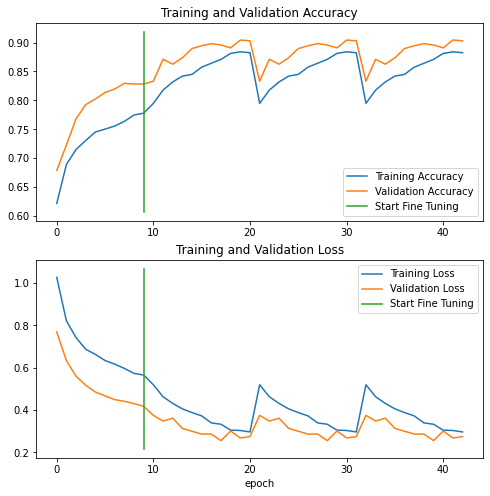

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

252/252 [==============================] - 81s 321ms/step - loss: 0.2887 - accuracy: 0.8948
Test accuracy : 0.8947892189025879


In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# TODO: show example classifications